In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [83]:
def load_data(filename):
    df = pd.read_csv(filename)
    dfOpen = np.array(df.Open)
    dfClose = np.array(df.Close)
    dfHigh = np.array(df.High)
    dfLow = np.array(df.Low)
    a = dfOpen.shape
    d = {}
    d['Open'] = dfOpen
    d['Close'] = dfClose
    d['High'] = dfHigh
    d['Low'] = dfLow
    return d

def calcMax(length, high):
    a = high.shape
    runningMax = np.zeros(a)
    runningMax[length-1] = max(high[:length])
    for i in range(length,a[0]):
        if high[i] >= runningMax[i-1]:
            runningMax[i] = high[i]
        elif runningMax[i-1] == high[i-length]:
            runningMax[i-1] = max(high[i-length+1:i+1])
        else:
            runningMax[i] = runningMax[i-1]
    return runningMax

def calcMin(length, low):
    a = low.shape
    runningLow = np.zeros(a)
    runningLow[length] = min(low[:length])
    for i in range(length,a[0]):
        if low[i] <= runningLow[i-1]:
            runningLow[i] = low[i]
        elif runningLow[i-1] == low[i-length]:
            runningLow[i] = min(low[i-length+1:i+1])
        else:
            runningLow[i] = runningLow[i-1]
    return runningLow

def calcSignal(length, rm, rl, high, low):
    a = rm.shape
    signal = np.zeros(a)
    for i in range(length,a[0]):
        if high[i] > rm[i-1]:
            if low[i] < rl[i-1]:
                signal[i] = 0
            else:
                signal[i] = 1
        elif low[i] < rl[i-1]:
            signal[i] = -1
    return signal

def calcDrawdown(portfolio):
    a = portfolio.shape
    drawdown = np.zeros(a)
    prevPeak = portfolio[0]
    for i in range(1,a[0]):
        if portfolio[i] < prevPeak:
            drawdown[i] = portfolio[i] - prevPeak
        elif portfolio[i] > prevPeak:
            prevPeak = portfolio[i]
    return drawdown







def calcTrades(length, stopPct, signal, close, Open, high, low, rm, rl):
    a = Open.shape
    trade = np.zeros(a)
    price = np.zeros(a)
    currentPos = 0.0
    prevPeak = 0.0
    prevTrough = 0.0
    for i in range(length,a[0]-1):
        if currentPos == 0:
            if signal[i] == 1: 
                trade[i] = 1
                currentPos = 1
                price[i] = max(rm[i-1], Open[i]);
                prevPeak = price[i]
            elif signal[i] == -1:
                trade[i] = -1
                currentPos = -1
                price[i] = min(rl[i-1],Open[i]);
                prevTrough = price[i]
        elif currentPos == 1:
            if high[i] > prevPeak:
                prevPeak = high[i]
            elif low[i] < (1-stopPct) * prevPeak:
                trade[i] = -1
                price[i] = min(Open[i], (1-stopPct)*prevPeak)
                currentPos = 0
        elif currentPos == -1:
            if low[i] < prevTrough:
                prevTrough = low[i]
            elif high[i] > (1 + stopPct) * prevTrough:
                trade[i] = 1
                price[i] = max(Open[i], (1+stopPct)*prevTrough)
                currentPos = 0
                
    if currentPos == 1:
        trade[a[0]-1] = -1
        price[a[0]-1] = close[a[0]-1]
    elif currentPos == -1:
        trade[a[0]-1] = 1
        price[a[0]-1] = close[a[0]-1]
    return trade, price

   
        

def calcPortfolio(length, stopPct, Open, high, low, close, capital,contractSize,slippage):
    runningMax = calcMax(length, high)
    runningMin = calcMin(length, low)
    signal = calcSignal(length, runningMax, runningMin, high, low)
    trades,prices = calcTrades(length, stopPct, signal, close, Open, high, low, runningMax, runningMin)
    a = Open.shape
    port = np.zeros(a)
    port[:length] = capital
    cash = capital
    currentPos = 0
    priceTraded = 0
    slippageThisTrade = 0
    
    for i in range(length, a[0]):
        port[i] = port[i-1] + currentPos*contractSize*(Open[i] - close[i-1])
        if trades[i] == 1:
            currentPos += 1
            slippageThisTrade = (1-abs(currentPos))*slippage
            priceTraded = prices[i]
            port[i] = port[i] + currentPos*contractSize*(close[i] - priceTraded) - (1-abs(currentPos))*contractSize*(priceTraded - Open[i])        
        elif trades[i] == -1:
            currentPos -= 1
            slippageThisTrade = (1-abs(currentPos))*slippage
            priceTraded = prices[i]
            port[i] = port[i] + currentPos*contractSize*(close[i] - priceTraded) + (1-abs(currentPos))*contractSize*(priceTraded - Open[i])        
        elif trades[i] == 0:
            slippageThisTrade = 0
            port[i] = port[i] + currentPos*contractSize*(close[i]-Open[i])
    return port

    

In [87]:
dTY = load_data('TY-5min.csv')
dTU = load_data('TU-5min.csv')


In [55]:
stopPct = 0.2
timeStep = 2000
capital = 10000.0
cz = 2000
slippage = 19
port = calcPortfolio(timeStep,stopPct,dTU['Open'],dTU['High'],dTU['Low'],dTU['Close'], capital,cz,slippage)
drawdown = calcDrawdown(port)
max(port)

89965.625000000087

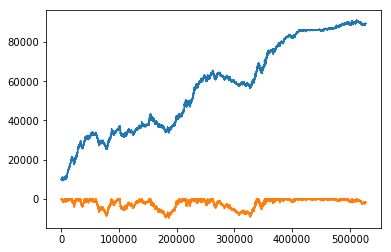

In [26]:
plt.plot(port)
plt.plot(drawdown)

In [94]:
arr = [0.01,0.02,0.03]
rng = np.array(arr)
del arr
rng2 = np.linspace(1000,9000,9)
#rng3 = np.linspace(20000,100000,5)
#rng2 = np.append(rng2,rng3)
vals = np.zeros((3,9))
sharpe = []
capital = 10000.0
cz = 1000
slippage = 19
count = 0
count1 = 0
for i in rng:
    for j in rng2:
        port = calcPortfolio(int(j),i,dTY['Open'],dTY['High'],dTY['Low'],dTY['Close'], capital,cz,slippage)
        vals[count,count1] = max(port)
        count1 = count1 + 1
        sharpe.append(np.mean(port)/np.std(port))
    print('Done')
    count1 = 0
    count = count + 1 
df = pd.DataFrame(vals)
df.columns = rng2
arr  = [str(x*100)+'%' for x in arr ]
df.index = arr


Done
Done
Done


In [7]:
df = pd.read_csv('CO-5min.asc')

In [9]:
df = pd.read

0         56.05
1         56.04
2         56.03
3         56.03
4         56.02
5         56.03
6         56.01
7         56.00
8         56.01
9         55.99
10        55.99
11        56.01
12        56.03
13        56.10
14        56.13
15        56.14
16        56.21
17        56.24
18        56.25
19        56.25
20        56.19
21        56.15
22        56.15
23        56.17
24        56.19
25        56.23
26        56.23
27        56.27
28        56.32
29        56.66
          ...  
230802    54.47
230803    54.47
230804    54.49
230805    54.52
230806    54.49
230807    54.47
230808    54.49
230809    54.47
230810    54.43
230811    54.40
230812    54.37
230813    54.36
230814    54.36
230815    54.39
230816    54.37
230817    54.37
230818    54.36
230819    54.35
230820    54.43
230821    54.38
230822    54.33
230823    54.32
230824    54.34
230825    54.37
230826    54.40
230827    54.41
230828    54.36
230829    54.40
230830    54.43
230831    54.37
Name: Open, dtype: float